<a href="https://colab.research.google.com/github/Karrthikpn/speechprocessing/blob/master/Emotion_recognitionmymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Karrthikpn/speechprocessing.git

Cloning into 'speechprocessing'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 32 (delta 8), reused 26 (delta 5), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [0]:
#import all the required libraries
import pandas as pd
import numpy as np

In [0]:
data=pd.read_csv("/content/speechprocessing/emotion_dataset/emotion.csv")
data.head()

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


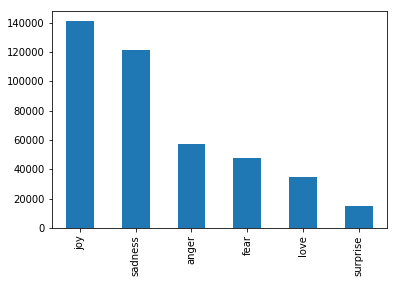

In [0]:
data.emotions.value_counts().plot.bar()

In [0]:
input_sentences=[text.split(" ") for text in data["text"].values.tolist() ]
labels=data["emotions"].values.tolist()

Data encoding 

In [0]:
word2id=dict()
label2id=dict()

max_words=0 #maximum words in a sentence

for sentence in input_sentences:
  for word in sentence:

    if word not in word2id:
      word2id[word]=len(word2id)

    if len(sentence)>max_words:
      max_words=len(sentence)

In [0]:
label2id={l : i for i,l in enumerate(set(labels))}
id2label={v : k for k,v in label2id.items()}
id2label

{0: 'love', 1: 'surprise', 2: 'anger', 3: 'sadness', 4: 'fear', 5: 'joy'}

In [0]:
X=[[word2id[word] for word in sentence] for sentence in input_sentences]
Y=[label2id[label] for label in labels]

In [0]:
import keras
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
X=pad_sequences(X,max_words)
Y=keras.utils.to_categorical(Y,num_classes=len(label2id),dtype="float32")

In [0]:
X.shape,Y.shape

((416809, 178), (416809, 6))

In [0]:
embeding_dim=100

In [0]:
sequence_input=keras.Input(shape=(max_words,),dtype="float32")

In [0]:
embedded_input=keras.layers.Embedding(len(word2id)+1,embeding_dim,input_length=max_words)(sequence_input)
embedded_input=keras.layers.Dropout(0.2)(embedded_input)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
lstm_outs=keras.layers.wrappers.Bidirectional(keras.layers.LSTM(embeding_dim,return_sequences=True))(embedded_input)
lstm_outs=keras.layers.Dropout(0.2)(lstm_outs)

In [0]:
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embeding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

In [0]:
model=keras.Model(input=(sequence_input),outputs=(output))
model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer="adam")
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 178)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 178, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 178, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 178, 200)     160800      dropout_1[0][0]                  
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [0]:
model.fit(X,Y,epochs=1,batch_size=64,validation_split=0.1,shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 375128 samples, validate on 41681 samples
Epoch 1/1
   320/375128 [..............................] - ETA: 3:15:37 - loss: 1.7717 - acc: 0.2687

KeyboardInterrupt: ignored

In [0]:
from sklearn.externals import joblib
joblib.dump(model,'erm.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
trained_model=joblib.load('/erm.pkl')